# Timescales of simulated LFPs
How does the PSP timescale and the population spiking timescale effect the LFP timescale?  
2x2 design

## Set-up

### package installation

In [1]:
! pip install neurodsp
! pip install fooof

### imports

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.spectral import compute_spectrum
from neurodsp.sim.transients import sim_synaptic_kernel
from fooof.plts.spectra import plot_spectrum
from fooof import FOOOF


C:\Users\micha\AppData\Local\Temp\ipykernel_15288\807245212.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.plts.spectra import plot_spectrum


### settings

In [3]:
FS = 1000 # sampling rate
COLORS = ["#7b3294", "#c2a5cf", "#008837", "#a6dba0"]

### functions

In [4]:
# general simulation functions

def sim_ou_process(n_seconds, fs, tau, mu=100., sigma=10.):
    ''' 
    Simulate an Ornstein-Uhlenbeck process with a dymanic timescale.
    
    
    Parameters
    ----------
    n_seconds : float
        Simulation time (s)
    fs : float
        Sampling rate (Hz)
    tau : float
        Timescale of signal (s)
    mu : float, optional, default: 100.
        Mean of signal
    sigma : float, optional, default: 10.
        Standard deviation signal

    Returns
    signal : 1d array
        Simulated Ornstein-Uhlenbeck process
    time : 1d array
        time vector for signal

    References
    ----------
    https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/
    
    '''

    # initialize signal and set first value equal to the mean
    signal = np.zeros(int(np.ceil(n_seconds * fs)))
    signal[0] = mu
    
    # define constants in OU equation (to speed computation) 
    dt = 1 / fs
    sqrtdt = np.sqrt(dt)
    rand = np.random.randn(len(signal))
    
    # simulate OU
    for ii in range(len(signal)-1):
        signal[ii + 1] = signal[ii] + \
                        dt * (-(signal[ii] - mu) / tau) + \
                        sigma * np.sqrt(2/tau) * sqrtdt * rand[ii]
    
    # define time vector
    time = np.linspace(0, n_seconds, len(signal))
    
    return signal, time


def sample_spikes(rand_p, fs):
    """
    Sample spikes from a random process

    Parameters
    ----------
    rand_p : 1D array, float
        random process (from which spikes will be sampled).
    fs : float
        sampling frequency (1/dt).

    Returns
    -------
    spikes : 1D array, int
        spike train

    """
    # initialize
    spikes = np.zeros([len(rand_p)])
        
    # loop through each time bin
    for i_bin in range(len(rand_p)):
        # sample spikes
        if rand_p[i_bin] / fs > np.random.uniform():
            spikes[i_bin] = 1    
    
    return spikes


def convolve_psps(spikes, fs, tau_r=0., tau_d=0.01, t_ker=None):
    """Adapted from neurodsp.sim.aperiodic.sim_synaptic_current
    
    Convolve spike train and synaptic kernel.

    Parameters
    ----------
    spikes : 1D array, int 
        spike train 
    tau_r : float, optional, default: 0.
        Rise time of synaptic kernel, in seconds.
    tau_d : float, optional, default: 0.01
        Decay time of synaptic kernel, in seconds.
    t_ker : float, optional
        Length of time of the simulated synaptic kernel, in seconds.

    Returns
    -------
    sig : 1d array
        Simulated synaptic current.
    time : 1d array
        associated time-vector (sig is trimmed  during convolution).

    """
    from neurodsp.sim.transients import sim_synaptic_kernel
    from neurodsp.utils import create_times
    
    # If not provided, compute t_ker as a function of decay time constant
    if t_ker is None:
        t_ker = 5. * tau_d

    # Simulate
    ker = sim_synaptic_kernel(t_ker, fs, tau_r, tau_d)
    sig = np.convolve(spikes, ker, 'valid')

    # compute time vector (convolve will trim when 'valid')
    times = create_times(len(spikes)/fs, fs)
    trim = len(times) - len(spikes)
    time = times[int(trim/2):-int(trim/2)-1]
    
    return sig, time


In [5]:
# main simulation function

def simulate_lfp(n_neurons=100, mean_rate=10, n_seconds=60, fs=1000, 
                 tau_pop_spike=None, tau_psp_rise=0., tau_psp_decay=0.01):
    
    # simulate rate process
    if tau_pop_spike is not None:
        rand_process, _ = sim_ou_process(n_seconds, fs, mu=mean_rate, sigma=mean_rate**0.5, tau=tau_pop_spike)
    else:
        rand_process = np.random.normal(loc=mean_rate, scale=mean_rate**0.5, size=n_seconds*fs)

    # simulate spiking
    spikes = []
    for i_neuron in range(n_neurons):
        spikes_i = sample_spikes(rand_process, fs)
        spikes.append(spikes_i)
    spikes = np.array(spikes)

    # simulate LFP
    pop_spikes = np.sum(spikes, axis=0)
    lfp, time = convolve_psps(pop_spikes, fs, tau_r=tau_psp_rise, tau_d=tau_psp_decay)

    # TEMP - correct time vector (this in a bug in convolve_psps)
    n_samples_dropped = len(time) - len(lfp)
    time = time[:-n_samples_dropped]

    return lfp, time

# def sim_ei_lfp(n_neurons_e=None, rate_e=2, tau_psp_e=[0.0001,0.002], tau_pop_e=None, \
#                 n_neurons_i=None, rate_i=5, tau_psp_i=[0.0005,0.01], tau_pop_i=None, 
#                 ei_ratio=0.5):
#     """
#     simulate LFP from a population of excitatory and inhibitory neurons
#     """
#     # simulate excitatory field
#     if n_neurons_e is not None:
#         lfp_e, time = simulate_lfp(n_neurons=n_neurons_e, mean_rate=rate_e, 
#                                 tau_pop_spike=tau_pop_e, tau_psp_rise=tau_psp_e[0], 
#                                 tau_psp_decay=tau_psp_e[1])

#     # simulate inhibitory field
#     if n_neurons_i is not None:
#         lfp_i, time = simulate_lfp(n_neurons=n_neurons_i, mean_rate=rate_i, 
#                                 tau_pop_spike=tau_pop_i, tau_psp_rise=tau_psp_i[0], 
#                                 tau_psp_decay=tau_psp_i[1])
        
#     # if only excitatory or inhibitory neurons, set other to zero
#     if n_neurons_e is None and n_neurons_i is not None:
#         lfp_e = np.zeros(len(lfp_i))
#     elif n_neurons_e is not None and n_neurons_i is None:
#         lfp_i = np.zeros(len(lfp_e))

#     # TEMP: trim to same length (this is a bug in simulate_lfp)
#     n_samples = np.min([len(lfp_e), len(lfp_i)]) 
#     lfp_e = lfp_e[:n_samples]
#     lfp_i = lfp_i[:n_samples]
#     time = time[:n_samples]

#     # combine excitatory and inhibitory fields
#     lfp = lfp_e * ei_ratio + lfp_i

#     return lfp, time
    


In [6]:
# analysis functions

def spectral_analysis(lfp, fs, normalize_power=False):
    """
    compute PSD, normalize (optional), parameterize, compute timescale
    """

    # compute LFP power spectrum
    freq, spectrum = compute_spectrum(lfp, fs)
    if normalize_power:
        spectrum = spectrum / np.mean(spectrum)

    # parameterize spectrum and compute timescale
    sm = FOOOF(max_n_peaks=0, aperiodic_mode='knee', verbose=False)
    sm.fit(freq, spectrum)
    timescale = compute_timescale(sm)

    return freq, spectrum, timescale


def compute_timescale(sp):
    """
    Compute timescale from specparam object. 

    Parameters
    ----------
    sp : specparam object
        SpectralModel.

    Returns
    -------
    timescale : float
        Timescale (ms).
    """

    k_param = sp.get_params('aperiodic_params', 'knee')
    exponent = sp.get_params('aperiodic_params', 'exponent')
    knee = k_param**(1/exponent)
    timescale = 1 / (2 * np.pi * knee) * 1000 # convert to ms

    return timescale

## Main

### Simulate 2x2 design

c:\Users\micha\anaconda3\envs\voytek_lab\lib\site-packages\fooof\plts\spectra.py:77: RuntimeWarning: divide by zero encountered in log10
  freqs = np.log10(freqs) if log_freqs else freqs


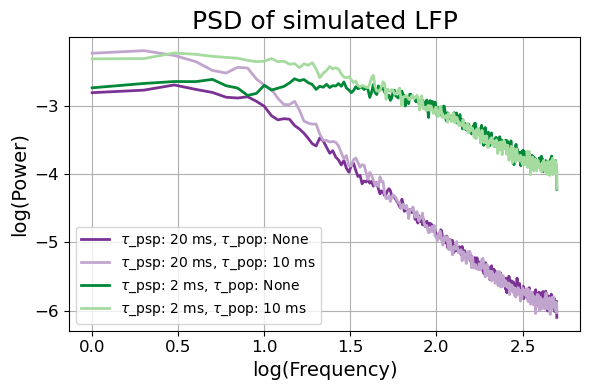

In [7]:
# simulate 2x2 design

# set parameters
tau_psp_long = 0.02
tau_psp_short = 0.002
tau_pop_spike = 0.01

# 00: long PSP timescale, short population timescale
lfp_00, time_00 = simulate_lfp(tau_psp_decay=tau_psp_long, tau_pop_spike=None)
freq_00, spectrum_00, timescale_00 = spectral_analysis(lfp_00, FS)

# 01: long PSP timescale, long population timescale
lfp_01, time_01 = simulate_lfp(tau_psp_decay=tau_psp_long, tau_pop_spike=tau_pop_spike)
freq_01, spectrum_01, timescale_01 = spectral_analysis(lfp_01, FS)

# 10: short PSP timescale, short population timescale
lfp_10, time_10 = simulate_lfp(tau_psp_decay=tau_psp_short, tau_pop_spike=None)
freq_10, spectrum_10, timescale_10 = spectral_analysis(lfp_10, FS)

# 11: short PSP timescale, long population timescale
lfp_11, time_11 = simulate_lfp(tau_psp_decay=tau_psp_short, tau_pop_spike=tau_pop_spike)
freq_11, spectrum_11, timescale_11 = spectral_analysis(lfp_11, FS)

# plot all spectra
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_title("PSD of simulated LFP")
plot_spectrum(freq_00, spectrum_00, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_01, spectrum_01, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_10, spectrum_10, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_11, spectrum_11, log_freqs=True, log_powers=True, ax=ax)

# update colors and add legend
for i, line in enumerate(ax.lines):
    line.set_color(COLORS[i])
ax.legend(labels=[f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: None",
                    f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms",
                    f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: None",
                    f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms"])
# ax.legend(labels=[f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: None, $\u03C4$_LFP: {timescale_00:.0f} ms",
#                     f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms, $\u03C4$_LFP: {timescale_01:.0f} ms",
#                     f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: None, $\u03C4$_LFP: {timescale_10:.0f} ms",
#                     f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms, $\u03C4$_LFP: {timescale_11:.0f} ms"])


plt.show()

Here we see that the PSP timescale is primarilly driving changes in high-frequency power, while the population spiking timescale is primarilly driving changes in low-frequency power.

### Repeat with normalization
In Gao 2017, spectra are normalized to have equal total power

c:\Users\micha\anaconda3\envs\voytek_lab\lib\site-packages\fooof\plts\spectra.py:77: RuntimeWarning: divide by zero encountered in log10
  freqs = np.log10(freqs) if log_freqs else freqs


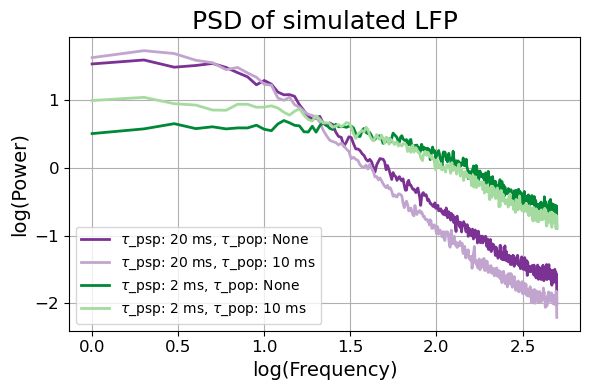

In [8]:
# simulate 2x2 design - normalize spectral power

# set parameters
tau_psp_long = 0.02
tau_psp_short = 0.002
tau_pop_spike = 0.01

# 00: long PSP timescale, short population timescale
lfp_00, time_00 = simulate_lfp(tau_psp_decay=tau_psp_long, tau_pop_spike=None)
freq_00, spectrum_00, timescale_00 = spectral_analysis(lfp_00, FS, normalize_power=True)

# 01: long PSP timescale, long population timescale
lfp_01, time_01 = simulate_lfp(tau_psp_decay=tau_psp_long, tau_pop_spike=tau_pop_spike)
freq_01, spectrum_01, timescale_01 = spectral_analysis(lfp_01, FS, normalize_power=True)

# 10: short PSP timescale, short population timescale
lfp_10, time_10 = simulate_lfp(tau_psp_decay=tau_psp_short, tau_pop_spike=None)
freq_10, spectrum_10, timescale_10 = spectral_analysis(lfp_10, FS, normalize_power=True)

# 11: short PSP timescale, long population timescale
lfp_11, time_11 = simulate_lfp(tau_psp_decay=tau_psp_short, tau_pop_spike=tau_pop_spike)
freq_11, spectrum_11, timescale_11 = spectral_analysis(lfp_11, FS, normalize_power=True)

# plot all spectra
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_title("PSD of simulated LFP")
plot_spectrum(freq_00, spectrum_00, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_01, spectrum_01, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_10, spectrum_10, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_11, spectrum_11, log_freqs=True, log_powers=True, ax=ax)

# update colors and add legend
for i, line in enumerate(ax.lines):
    line.set_color(COLORS[i])
ax.legend(labels=[f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: None",
                    f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms",
                    f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: None",
                    f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms"])
# ax.legend(labels=[f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: None, $\u03C4$_LFP: {timescale_00:.0f} ms",
#                     f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms, $\u03C4$_LFP: {timescale_01:.0f} ms",
#                     f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: None, $\u03C4$_LFP: {timescale_10:.0f} ms",
#                     f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms, $\u03C4$_LFP: {timescale_11:.0f} ms"])


plt.show()

With normalization, both timescale manipulations appear as spectral roations about a central frequency.

### Analyze power spectra of PSP kernels and spike rate processes
(without simulating spikes and LFP). These should underly differences in the LFP spectra.

c:\Users\micha\anaconda3\envs\voytek_lab\lib\site-packages\fooof\plts\spectra.py:77: RuntimeWarning: divide by zero encountered in log10
  freqs = np.log10(freqs) if log_freqs else freqs


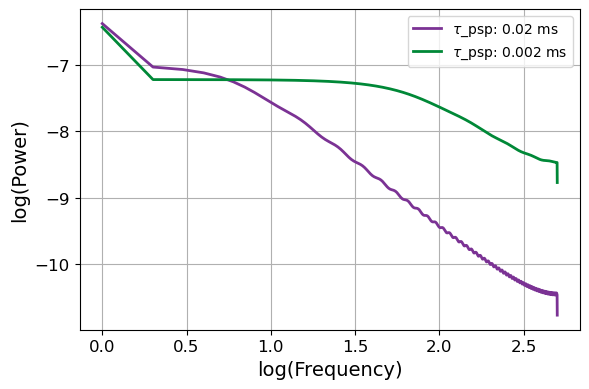

In [9]:
# analyze kernel spectra

# simulate long timescale kernel
tau_d = 0.02
ker_02 = sim_synaptic_kernel(5*tau_d, FS, 0, tau_d)
ker_02 = np.concatenate([np.zeros(1000), ker_02, np.zeros(1000)]) # zero pad kernel
freq_02, spectrum_02, timescale_02 = spectral_analysis(ker_02, FS)

# simulate short timescale kernel
tau_d = 0.002
ker_002 = sim_synaptic_kernel(5*tau_d, FS, 0, tau_d)
ker_002 = np.concatenate([np.zeros(1000), ker_002, np.zeros(1000)]) # zero pad kernel
freq_002, spectrum_002, timescale_002 = spectral_analysis(ker_002, FS)

# plot spectra
fig, ax = plt.subplots(1,1, figsize=[6,4])
plot_spectrum(freq_02, spectrum_02, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_002, spectrum_002, log_freqs=True, log_powers=True, ax=ax)
for line, color in zip(ax.lines, COLORS[::2]):
    line.set_color(color)
ax.legend(labels=["$\u03C4$_psp: 0.02 ms", "$\u03C4$_psp: 0.002 ms"])
plt.show()

as in the full simulation, changes in the PSP timescale primarilly effect high-frequency power

c:\Users\micha\anaconda3\envs\voytek_lab\lib\site-packages\fooof\plts\spectra.py:77: RuntimeWarning: divide by zero encountered in log10
  freqs = np.log10(freqs) if log_freqs else freqs


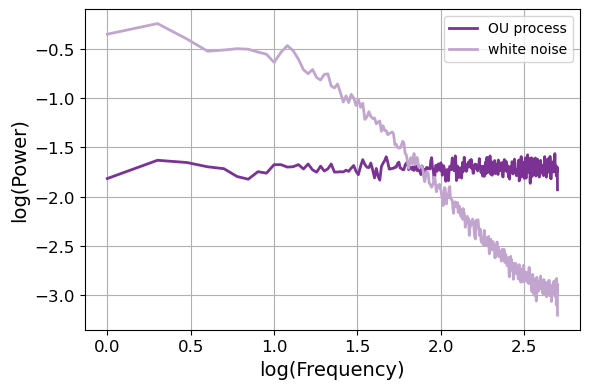

In [10]:
# Analyze spectra of population firing rates

# default func params
n_neurons=100
mean_rate=10
n_seconds=60
fs=1000
tau_pop_spike=0.01 # population timescale
tau_psp_rise=0.
tau_psp_decay=0.01
    
# simulate rate process
rp_sync, _ = sim_ou_process(n_seconds, fs, mu=mean_rate, sigma=mean_rate**0.5, tau=tau_pop_spike)
rp_desync = np.random.normal(loc=mean_rate, scale=mean_rate**0.5, size=n_seconds*fs)

# compute timecale
freq_desync, spectrum_desync, timescale_desync = spectral_analysis(rp_desync, fs)
freq_sync, spectrum_sync, timescale_sync = spectral_analysis(rp_sync, fs)

# plot all spectra
fig, ax = plt.subplots(1,1, figsize=[6,4])
plot_spectrum(freq_desync, spectrum_desync, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_sync, spectrum_sync, log_freqs=True, log_powers=True, ax=ax)
for line, color in zip(ax.lines, COLORS[:2]):
    line.set_color(color)
ax.legend(labels=[f"OU process", f"white noise"])
plt.show()


While the spectrum of the white noise process has approximately equal power at all frequencies, the spectrum of the OU process exhibits a clear 'knee' and a 1/f-like shape. Comparing these spectra, we see the OU process has increased power at low frequencies and decreased power at high frequencies; this effect at high-frequencies is not seen in the full simulation.

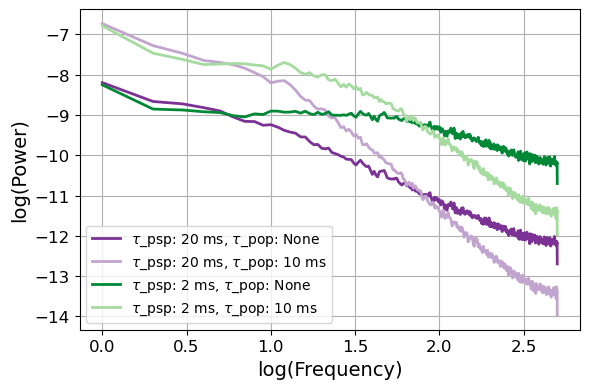

In [11]:
# Plot combined spectra - 2x2 design

# perform 2x2 multiplication of spectra 
spectrum_00 = spectrum_02 * spectrum_desync
spectrum_01 = spectrum_02 * spectrum_sync
spectrum_10 = spectrum_002 * spectrum_desync
spectrum_11 = spectrum_002 * spectrum_sync

# plot 
fig, ax = plt.subplots(1,1, figsize=[6,4])
plot_spectrum(freq_00, spectrum_00, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_01, spectrum_01, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_10, spectrum_10, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq_11, spectrum_11, log_freqs=True, log_powers=True, ax=ax)
for line, color in zip(ax.lines, COLORS):
    line.set_color(color)
ax.legend(labels=[f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: None",
                    f"$\u03C4$_psp: {tau_psp_long*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms",
                    f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: None",
                    f"$\u03C4$_psp: {tau_psp_short*1000:.0f} ms, $\u03C4$_pop: {tau_pop_spike*1000:.0f} ms"])
plt.show()

Here we largely recapitulate the findings from the full simulation. The only noteworthy difference is the decrease in high-frequency power upon introduction of the population timescale which was not seen in the full simulation.